In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
import re
import folium

In [3]:
import networkx as nx
import osmnx as ox

In [4]:
from networkx.algorithms.community import greedy_modularity_communities

In [5]:
import scipy
import numpy as np

In [6]:
import libpysal as lp
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import itertools

In [8]:
def knn(adj,k=1):
    g = nx.from_pandas_adjacency(adj)
    knn = nx.DiGraph()
    for node in g.nodes():
        neighbors = g.neighbors(node)
        edges = sorted([(node,neighbor,g.edges[node,neighbor]['weight']) for neighbor in neighbors],key=lambda x:x[2])
        for edge in edges[0:k]:
            u,v,w = edge
            knn.add_edge(u,v,weight=w)
    return knn

In [9]:
def distance_matrix(df,index_vals,p):
    adj = pd.DataFrame(scipy.spatial.distance_matrix(x=df,y=df,p=p),index=index_vals,columns=index_vals)
    return adj

In [10]:
def network_area(nodelist,nodes):
    ch_nodes = nodes[nodes.index.isin(nodelist)]
    un = ch_nodes.unary_union
    ch = un.convex_hull
    return ch.area

In [11]:
def entropy(g):
    x, y = dict(), dict()
    for node in g.nodes():
        x[node] = node[0]
        y[node] = node[1]

    nx.set_node_attributes(g,x,'x')
    nx.set_node_attributes(g,y,'y')
    
    g = nx.convert_node_labels_to_integers(g)
    osmids = {node:node for node in g.nodes()}
    nx.set_node_attributes(g,osmids,'osmid') 
    
    g = ox.project_graph(g,to_crs='EPSG:4326')
    g = g.to_undirected()    
    ox.add_edge_bearings(g) 
    
    entr = ox.bearing.orientation_entropy(g)
    return entr

In [12]:
g = ox.load_graphml('redes/rede de ruas osmnx.graphml')
ox.add_edge_bearings(g)
print(g.order(),g.size())

293399 720864


In [13]:
base = gpd.read_parquet('arquivos de base/arquivos geoespaciais/geosampa/limites administrativos/distritos/distritos.parquet')
base = base.set_crs('EPSG:31983')

In [14]:
pts_onibus = gpd.read_parquet('arquivos de base/arquivos geoespaciais/geosampa/rede de ônibus/ponto de ônibus/ponto de ônibus.parquet')
pts_onibus = pts_onibus.set_crs('EPSG:31983')

pts_ilum = gpd.read_parquet('arquivos de base/arquivos geoespaciais/geosampa/iluminação/iluminação.parquet')
pts_ilum = pts_ilum.set_crs('EPSG:31983')

declividade = gpd.read_parquet('arquivos de base/arquivos geoespaciais/geosampa/declividade/declividade.parquet')
declividade = declividade.set_crs('EPSG:31983')

inundaveis = gpd.read_parquet('arquivos de base/arquivos geoespaciais/geosampa/área inundável/área inundável.parquet')
inundaveis = inundaveis.set_crs('EPSG:31983')

In [15]:
nodes,edges = ox.graph_to_gdfs(g)
nodes = nodes.to_crs(base.crs)
edges = edges.to_crs(base.crs)

In [129]:
fav = gpd.read_parquet('arquivos de base/arquivos geoespaciais/geosampa/favelas/favelas - preprocessado.parquet')
#fav = fav[(fav['anoocupacao']>0)]
#fav = fav[(fav['totdomicilio']>0)]
fav['scale'] = pd.qcut(fav['totdomicilio'],5,range(5))
fav = fav.to_crs(base.crs)
fav.shape

(1974, 23)

In [130]:
fav['areageo_km2'] = fav['areageo_m2']/10**6
fav['areageo_km2'].describe()

count    1974.000000
mean        0.013031
std         0.032951
min         0.000022
25%         0.001371
50%         0.004405
75%         0.012691
max         0.788094
Name: areageo_km2, dtype: float64

In [88]:
buffers = [0,50,100,200,400]
buffers

[0, 50, 100, 200, 400]

In [89]:
fav_circle = fav.copy()
fav_circle['geometry'] = fav_circle.geometry.minimum_bounding_circle()
fav_circle['geometry'] = fav_circle.buffer(0)
fav_circle['area'] = fav_circle.area
s0 = edges.sjoin(fav_circle)

In [90]:
redes = {}
for nome in sorted(fav.nome):
    gdf = s0[s0['nome']==nome].index.values.tolist()
    j = nx.edge_subgraph(g,gdf)
    try:
        lcc = max(nx.weakly_connected_components(j),key=len)
        j_lcc = nx.induced_subgraph(j,lcc)
        if (j_lcc.size() >= 3):
            redes[nome] = j
    except ValueError:
        pass

In [91]:
print(len(redes))

1446


In [92]:
fav_cf = fav.copy()
fav_cf = fav_cf[fav_cf['nome'].isin(list(redes.keys()))]
fav_cf['geometry'] = fav_cf['geometry'].minimum_bounding_circle()

gdfs = {}
busgdfs = {}
ilugdfs = {}
decgdfs = {}
for buffer in buffers:
    valgdf = fav_cf.copy()
    valgdf['geometry'] = valgdf['geometry'].buffer(buffer)
    valgdf['area'] = valgdf['geometry'].area
    sval = edges.sjoin(valgdf)
    busval = pts_onibus.sjoin(valgdf)
    iluval = pts_ilum.sjoin(valgdf)
    decgdf = declividade.sjoin(valgdf)
    gdfs[buffer] = sval
    busgdfs[buffer] = busval
    ilugdfs[buffer] = iluval
    decgdfs[buffer] = decgdf

In [93]:
op = []
for buffer in buffers:
    gdf = gdfs[buffer]
    busgdf = busgdfs[buffer]
    ilugdf = ilugdfs[buffer]
    decgdf = decgdfs[buffer]
    for rede in redes.keys():
        edgelist = gdf[gdf['nome']==rede]
        h = nx.edge_subgraph(g,edgelist.index.values.tolist())
        #area = network_area(list(h.nodes()),nodes)
        area = edgelist['area_right'].values[0]
        areakm = area*1/(10**6)
        stats = ox.basic_stats(h,area=area)
        stats['entropy'] = ox.bearing.orientation_entropy(h.to_undirected())
        stats['buffer'] = buffer
        stats['ptbus'] = len(busgdf[busgdf['nome']==rede])/areakm
        stats['ptilu'] = len(ilugdf[ilugdf['nome']==rede])/areakm
        stats['meandec'] = decgdf[decgdf['nome']==rede]['CODIGO'].mean()
        stats['vardec'] = decgdf[decgdf['nome']==rede]['CODIGO'].var()
        stats['nome'] = rede
        op.append(stats)
    print(buffer)

C:\Users\User\anaconda3\envs\conso\lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])
C:\Users\User\anaconda3\envs\conso\lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])
C:\Users\User\anaconda3\envs\conso\lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])
C:\Users\User\anaconda3\envs\conso\lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])
C:\Users\User\anaconda3\envs\conso\lib\site-pack

0
50
100
200
400


In [94]:
outputs = pd.DataFrame(op)
outputs = outputs.drop(columns=['streets_per_node_counts','streets_per_node_proportions','self_loop_proportion'])
outputs.to_parquet('outputs - 4.parquet')

In [131]:
outputs = pd.read_parquet('outputs - 3.parquet')
print(len(pd.unique(outputs['nome'])))

1448


In [132]:
outputs = outputs.rename(columns={'m':'num. edges',
                                  'edge_density_km': 'edge density',
                                  'circuity_avg': 'avg. circuity'})

In [133]:
label = 'viaspavimentadas'
outputs['totdomicilio'] = outputs['nome'].map(fav[['nome','totdomicilio']].set_index('nome')['totdomicilio'])
outputs['areageo_km2'] = outputs['nome'].map(fav[['nome','areageo_km2']].set_index('nome')['areageo_km2'])
outputs['scale'] = pd.qcut(outputs['totdomicilio'],5,labels=range(5)).astype(int)
outputs[label] = outputs['nome'].map(fav[['nome',label]].set_index('nome')[label])

In [134]:
outputs['edge density'] = outputs['edge density']/1000

In [135]:
outputs

n  num. edges     k_avg  ...  areageo_km2  scale  viaspavimentadas
0      56         114  4.071429  ...     0.052205      4               1.0
1       4           6  3.000000  ...     0.002028      0              10.0
2      28          58  4.142857  ...     0.002368      3              10.0
3      17          32  3.764706  ...     0.003345      1               0.0
4       6           8  2.666667  ...     0.001591      0              10.0
...   ...         ...       ...  ...          ...    ...               ...
7235  219         506  4.621005  ...     0.006172      2               5.0
7236  216         564  5.222222  ...     0.002179      0              10.0
7237  180         449  4.988889  ...     0.010970      2               0.0
7238  239         554  4.635983  ...     0.011676      3               5.0
7239  208         495  4.759615  ...     0.003080      1               9.0

[7240 rows x 26 columns]

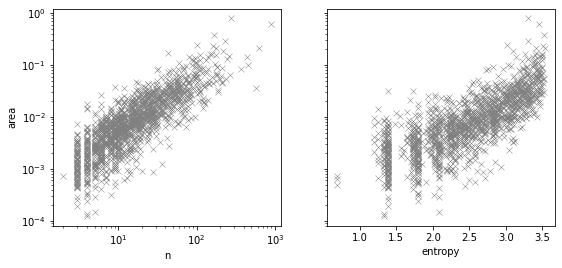

In [136]:
figpath = 'figs/'
fig, ax = plt.subplots(figsize=(9,4),ncols=2,sharey=True)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

#ax[1].set_xscale('log')
ax[1].set_yscale('log')

sns.scatterplot(data=outputs[outputs['buffer']==0],
                x='n',
                y='areageo_km2',
                marker='x',
                color='gray',
                ax=ax[0])
sns.scatterplot(data=outputs[outputs['buffer']==0],
                x='entropy',
                y='areageo_km2',
                marker='x',
                color='gray',
                ax=ax[1])

ax[0].set_ylabel('area')
fig.savefig(figpath + 'scaling relations.jpg')

In [137]:
norm_outputs = outputs.copy()
cols = outputs.select_dtypes(['int','float']).columns.values.tolist()
cols.remove('buffer')
norm_outputs[cols] = (outputs[cols] - outputs[cols].mean())/(outputs[cols].std())

In [142]:
p = 2
k = 2

In [143]:
vals = ['entropy','avg. circuity','edge density','num. edges']
combs = list(itertools.combinations(vals,2))

In [144]:
clugraphs = dict()
for val in vals:
    m = norm_outputs.pivot(index='buffer',columns='nome', values=val)
    #m = m.pct_change()
    #m = m.fillna(0)
    dm = distance_matrix(df=m.T,index_vals=m.columns,p=p)
    adj = nx.from_pandas_adjacency(dm)
    clugraphs[val] = nx.minimum_spanning_tree(adj, weight='weight')


    for edge in clugraphs[val].edges():
        weight = clugraphs[val].edges[edge]['weight']
        clugraphs[val].edges[edge]['i_weight'] = 1/(10**-7 + weight)
        
    
    d =  outputs[(outputs['buffer']==400)]
    for node in clugraphs[val].nodes():
        attrs = d[d['nome']==node]
        bus = attrs['ptbus'].values[0]
        lu = attrs['ptilu'].values[0]
        dec = attrs['meandec'].values[0]
        est = attrs[label].values[0]
        clugraphs[val].nodes[node]['ptbus'] = bus
        clugraphs[val].nodes[node]['ptilu'] = lu
        clugraphs[val].nodes[node]['dec'] = dec
        clugraphs[val].nodes[node]['est'] = est
    print(val)

entropy
avg. circuity
edge density
num. edges


In [145]:
for val in vals:
    x = nx.numeric_assortativity_coefficient(clugraphs[val],attribute='ptilu')
    y = nx.numeric_assortativity_coefficient(clugraphs[val],attribute='ptbus')
    z = nx.numeric_assortativity_coefficient(clugraphs[val],attribute='dec')
    print(val,';',round(x,5),';',round(y,5),';',round(z,5))

entropy ; -0.00282 ; -0.03824 ; 0.1916
avg. circuity ; 0.15459 ; 0.02989 ; 0.22832
edge density ; 0.48965 ; 0.13881 ; 0.02054
num. edges ; 0.47713 ; 0.16459 ; 0.03503


In [113]:
coms = dict()
for val in vals:
    coms[val] = greedy_modularity_communities(clugraphs[val],weight='i_weight')
    print(val, len(coms[val]))

entropy 37
avg. circuity 36
edge density 38
num. edges 40


In [48]:
com_favs = dict()
count = 0
for u, v in combs:
    com_favs[u,v] = []
    for com0 in coms[u]:
        for com1 in coms[v]:
            ints = com0.intersection(com1)
            if len(ints) >= 4:
                fav_int = outputs[outputs.nome.isin(ints)]
                com_favs[u,v].append(fav_int[[u,v,'scale','buffer']].groupby('buffer').mean())
    com_favs[u,v] = pd.concat(com_favs[u,v]).reset_index()
    print(u,v,len(com_favs[u,v]),count)
    count += 1

entropy avg. circuity 320 0
entropy edge density 380 1
entropy num. edges 470 2
avg. circuity edge density 285 3
avg. circuity num. edges 275 4
edge density num. edges 525 5


In [56]:
u,v = combs[5]
print(u,v)
fig, ax = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)

newbuff = [0,100,400]
labels = ['a','b','c']
color = ['red','blue','green']

for i in range(len(ax)):
    #ax[i].set_xscale('log')
    #ax[i].set_yscale('log')
    buffer = newbuff[i]
    d = com_favs[u,v]
    d = d[d['buffer']==buffer].copy()
    #d[u] = np.log(d[u])
    #d[v] = np.log(d[v])
    sns.scatterplot(data=d, x=u, y=v, color=color[i], ax=ax[i], hue='scale')
    print(i)
    ax[i].legend()
    ax[i].set_xlabel(u)
    ax[i].set_ylabel(v)
    #ax[i].set_xlabel('log('+u+')')
    #ax[i].set_ylabel('log('+v+')')
    ax[i].set_title('buffer = '+ str(buffer) + 'm')

fig.suptitle('Intersections between' + ' ' +  u + ' ' + 'and' + ' ' + v, fontsize=15)
fig.tight_layout()
fig.savefig(figpath + str(v)+'-'+str(u)+'.jpg')

IndexError: list index out of range

In [57]:
edges_base = edges.sjoin(base.set_index('ds_nome'))    

In [58]:
density = {}
for ds in base['ds_nome']:
    ind = edges_base[edges_base['index_right']==ds].index
    density[ds] = len(ind)
basec = base.copy()
basec['density'] = basec['ds_nome'].map(density)/basec['ds_areakmt']

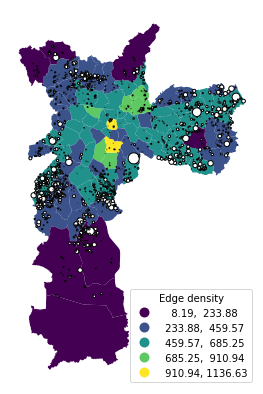

In [59]:
fav_centroid = fav.copy()
fav_centroid['geometry'] = fav_centroid['geometry'].centroid
mintot, maxtot = fav_centroid['totdomicilio'].min(), fav_centroid['totdomicilio'].max()
dif = maxtot-mintot


fav_centroid['totdomicilio'] = (fav_centroid['totdomicilio'] - mintot)/(dif)


fig, ax = plt.subplots(figsize=(7,7))
basec.plot(column='density',legend=True, scheme='equalinterval',ax=ax,legend_kwds={'loc':'lower right','title':'Edge density'})
fav_circle.plot(markersize=fav_centroid['totdomicilio']*100,color='white',ax=ax,edgecolor='black')
ax.axis('off')
fig.savefig(figpath + 'edge_density_distribution.jpg')

In [64]:
mpivot0 = outputs.pivot(index='buffer',values='avg. circuity',columns='nome').diff().dropna()
mpivot1 = outputs.pivot(index='buffer',values='entropy',columns='nome').diff().dropna()

mpivot0 = mpivot0.loc[:, (mpivot0 < 0).all(axis=0)]
mpivot1 = mpivot1.loc[:, (mpivot1 > 0).all(axis=0)]
cols = set(mpivot0.columns.values.tolist()).intersection(set(mpivot1.columns.values.tolist()))
print(mpivot0.shape,mpivot1.shape)

(4, 172) (4, 1041)


In [65]:
intersection = []
nodes = []
for comA in coms['entropy']:
    for comB in coms['avg. circuity']:     
        val = comA.intersection(comB)
        #val = val.intersection(cols)
        if len(val) > 1:
            intersection.append(val)
            for node in val:
                nodes.append(node)
intersection = sorted(intersection,key=len,reverse=True)

In [67]:
dfs = []
for i in range(len(intersection)):
    x = outputs[(outputs['nome'].isin(intersection[i]))]
    if len(x[(x['entropy']>2.99) & (x['avg. circuity']>1.09)]) > 0:
        dfs.append(x)
print(len(dfs))

155


In [68]:
cols = ['avg. circuity', 'entropy', 'n', 'buffer', 'nome']
ind = 0
myopt0 = pd.concat([dfs[i] for i in range(len(dfs))])
myopt0 = myopt0.set_index('nome')
print(myopt0.shape[0]/5)

438.0


In [69]:
dfs = []
for i in range(len(intersection)):
    x = outputs[(outputs['nome'].isin(intersection[i]))]
    if len(x[(x['entropy']<2.02) & (x['avg. circuity']<1.01)]) > 0:
        dfs.append(x)
print(len(dfs))

54


In [70]:
cols = ['avg. circuity', 'entropy', 'n', 'buffer', 'nome']
ind = 0
myopt1 = pd.concat([dfs[i] for i in range(len(dfs))])
myopt1 = myopt1.set_index('nome')
print(myopt1.shape[0]/5)

174.0


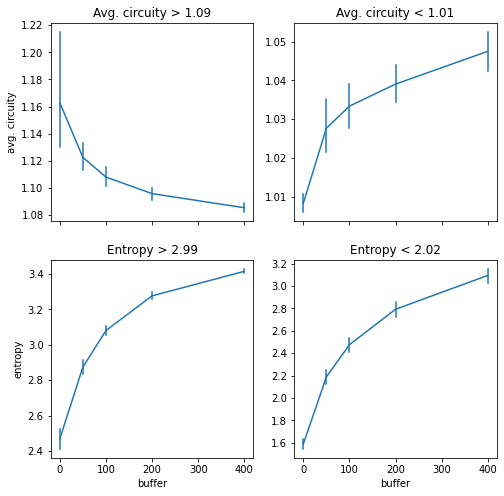

In [71]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,8),sharex=True)

sns.lineplot(data=myopt0,x='buffer',y='avg. circuity',ax=ax[0][0],err_style='bars')
ax[0][0].set_title('Avg. circuity > 1.09')

sns.lineplot(data=myopt0,x='buffer',y='entropy',ax=ax[1][0],err_style='bars')
ax[1][0].set_title('Entropy > 2.99')

sns.lineplot(data=myopt1,x='buffer',y='avg. circuity',ax=ax[0][1],err_style='bars')
ax[0][1].set_title('Avg. circuity < 1.01')

sns.lineplot(data=myopt1,x='buffer',y='entropy',ax=ax[1][1],err_style='bars')
ax[1][1].set_title('Entropy < 2.02')

ax[0][1].set_ylabel('')
ax[1][1].set_ylabel('')
fig.savefig('circ-ent.jpg',dpi=300)